# Final Project: Prediction of Ferromagnetic Quantum Dot Geometry with a Neural Network on Magnetic Resonance Spectra

## Project Source
Research from Hammel Group / Center for Emergent Materials.

Simulation datasets generated with Mumax3 – a micromagnetic simulator.

## Objectives / Goals
* Simulate training data from MuMax3, which creates large datasets describing the time evolution of a magnetic landscape.
* Make simulations be of magnetic dots cleaved in steps from the edge to the center of the dot, and use a specific range of external magnetic field to resonate the dots.
* Build a neural network model that predicts coordinates of a cut within a single dot, having given the model a measurement of the magnetic resonance linewidth.
* Test the model on simulated datasets also from MuMax3, assessing accuracy, precision, and mean squared error.
* Success considered to be when the model was reaching 80-90% accuracy.

- - -

# Setup

## Options

In [1]:
DATA_TLD = '/users/PAS1495/simba/simba'
#DATA_TLD = '/users/PAS1495/simba/repos/bigdata_6820-simbaryan/finalProject'
DATA_DIR_ID = '.out'
CUT_OFFSET = 5e-6
TEST_TRAIN_SPLIT = 0.2

## Imports

In [16]:
from ovf_reduced import OVF
from Simulation import FieldSweep

import os
import re
import math
#import random
#import argparse
import numpy as np
from numpy import genfromtxt
import pandas as pd
from collections import defaultdict
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import confusion_matrix

#from keras import backend as K
from keras import models
from keras import layers
from keras import metrics
from keras import regularizers
#import keras.preprocessing.image as kpi
from keras.models import load_model
#from keras.models import Model
#from keras.models import Sequential
#from keras.layers import Input, Dense
#from keras.layers import Dropout, Flatten, Reshape
#from keras.layers import Lambda
#from keras.losses import binary_crossentropy
#from keras.losses import mse
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
#from keras.utils import plot_model

import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go

from timeit import default_timer as timer

## Methods

In [3]:
#Multi-dimensional counter we need in the performance class
def autovivify(levels=1, final=dict):
    return (defaultdict(final) if levels < 2
            else defaultdict(lambda: autovivify(levels-1, final)))

In [15]:
def enable_plotly_in_cell():
    import IPython
    from plotly.offline import init_notebook_mode
    init_notebook_mode(connected=True)

- - -

# Process OVF Data Files (SEE NOTE!)

This code will walk across all MuMax3 output directories (\*.out) it sees in DATA_TLD, reading in and processing all raw OVF files. It contains commented-out code to create a final magnetization landscape OVF for each set of m0.ovf (equilibrium state) and f1-0.ovf (excited/precessing state) files, but this is not necessary. Instead, the default functionality is to go right for creating \*.csv files out of all the final magnetizations, which are 1024x1024 spatial grids read in as Numpy arrays.

**NOTE: The OVF data files have already been converted to CSVs, so THIS CODE DOES NOT NEED TO BE RUN!**

However, it is built with safety measures in case it is accidentally run again (i.e. it won't do anything if each set of m0/f1-0 files has an associated mf.ovf or mf.csv). If for some reason the CSVs are not already present, it only needs to be run once, but it takes about 50 minutes to run, so it should be done as a batch job. The appropriate files for this job are ovf_to_csv.sh and ovf_to_csv.py.

In [4]:
#Benchmark how long processing the data takes
timer_start = timer()

for subdir, dirs, files in os.walk(DATA_TLD):
    #Walk through each *.DATA_DIR_ID folder in the DATA_TLD directory
    if DATA_DIR_ID in subdir and DATA_DIR_ID+'/' not in subdir:
        print("------------------------------------------------------------")
        print("Now walking through", subdir)
        #
        #Need the cut position from the folder name so that the cutting region can be zero'd out
        cut_pos = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)", subdir)
        if(cut_pos):
            cut_pos = float(cut_pos[0])
        else:
            cut_pos = -1
        #
        #Need separate lists of only the m0.ovf and f1-0.ovf files in the subdir
        M0_FILES = []
        F1_FILES = []
        for i in range(len(files)):
            if ('.ovf' and 'm0') in files[i]:
                file_index = files[i].split("-")[0]
                M0_FILES.append(files[i])
                F1_FILES.append(file_index+'-f1-0.ovf')
            #/if
        #/for
        #
        #Instantiate the FieldSweep object to handle the OVF creation (OVFs ONLY)
        #fs = FieldSweep(subdir, file_index)
        #print("File count:", fs.numFiles)
        #print()
        #
        #Open a temporary header file (OVFs ONLY)
        #fs.create_header_file()
        #
        #Loop through all of the found files and process them into mf's (or skip if mf already exists for any given m0/f1 set)
        for i in range(len(M0_FILES)):
            #File index probably is not 0, so find out what it is
            file_index = M0_FILES[i].split("-")[0]
            #
            #################################################################################
            #If the mf exists already, just skip and keep going
            #  Else create the mf out of the m0/f1 pair
            #if fs.check_ovf_files_exist(file_index, '-mf'):
            #    print("\nAlready have ", str(file_index), "-mf.ovf", sep='')
            #    mf_ovf = OVF(subdir, str(file_index)+'-mf.ovf')
            #    mf_ovf.read_m_data()
            #    dM = mf_ovf.m
            #else:
            #    print("\nProcessing ", M0_FILES[i], " and ", F1_FILES[i], "...", sep='')
            #    m0_ovf = OVF(subdir, M0_FILES[i]) #Equilibrium direction of magnetization, which gets subtracted out from final state
            #    m0_ovf.read_m_data()
            #    f1_ovf = OVF(subdir, F1_FILES[i]) #Perturbed direction of magnetization, which is the final system state
            #    f1_ovf.read_m_data()
            #    dM = f1_ovf.m
            #    for j in ['mx','my','mz']:
            #        dM[j] = f1_ovf.m[j] - m0_ovf.m[j] #Change in magnetization from ground state
            #    #/for
            #    fs.save_numpy_array_to_ovf(dM, file_index) #Save evolved state as a new OVF file
            ##/if
            #print(dM[0]) #View just a sample to make sure component values seem correct
            #print()
            #################################################################################
            if str(file_index)+'-mf.csv' in files:
                print("\nAlready have ", str(file_index), "-mf.csv", sep='')
            else:
                print("\nProcessing ", M0_FILES[i], " and ", F1_FILES[i], "...", sep='')
                m0_ovf = OVF(subdir, M0_FILES[i]) #Equilibrium direction of magnetization, which gets subtracted out from final state
                m0_ovf.read_m_data()
                f1_ovf = OVF(subdir, F1_FILES[i]) #Perturbed direction of magnetization, which is the final system state
                f1_ovf.read_m_data()
                dM = f1_ovf.m
                for j in ['mx','my','mz']:
                    dM[j] = f1_ovf.m[j] - m0_ovf.m[j] #Change in magnetization from ground state
                #/for
                #
                #Create an empty grid
                mf = np.empty([1024,1024], dtype=float)
                #Set the zero boundary based on the cutting region's position
                if(cut_pos > 0):
                    zerox = round((cut_pos-CUT_OFFSET - m0_ovf.dx/2.0 + m0_ovf.Nx/2 * m0_ovf.dx) / m0_ovf.dx)
                #Calculate magnetization magnitudes
                for j in range(len(dM)):
                    for k in range(len(dM)):
                        if (cut_pos > 0) and (k >= zerox):
                            mf[j][k] = 0
                        else:
                            mf[j][k] = math.sqrt(dM[j][k][0]**2 + dM[j][k][1]**2 + dM[j][k][2]**2)
                np.savetxt(subdir+'/'+str(file_index)+'-mf.csv', mf, delimiter=',')
                print("\tCreated ", str(file_index), "-mf.csv", "\n\tContains: ", type(mf), " of shape ", mf.shape, "\n\tDatatypes: ", type(mf[0][0]), "\n\tSample: ", mf[0][0], sep='')
            #/if
            #################################################################################
        #/for
        #
        #Remove the temporary header file (OVFs ONLY)
        #fs.delete_header_file()
   #/if
#/for

#Print the benchmark
timer_end = timer() - timer_start
print("\nTime to run:", str(timer_end))

------------------------------------------------------------
Now walking through /users/PAS1495/simba/simba/dotcleaver_cutx=8.4e-6.out

Already have 7-mf.csv

Already have 8-mf.csv

Already have 10-mf.csv

Already have 9-mf.csv

Already have 12-mf.csv

Already have 11-mf.csv
------------------------------------------------------------
Now walking through /users/PAS1495/simba/simba/dotcleaver_cutx=8.8e-6.out

Already have 7-mf.csv

Already have 8-mf.csv

Already have 10-mf.csv

Already have 9-mf.csv

Already have 12-mf.csv

Already have 11-mf.csv
------------------------------------------------------------
Now walking through /users/PAS1495/simba/simba/dotcleaver_cutx=5.00e-6.out

Already have 6-mf.csv

Already have 7-mf.csv

Already have 8-mf.csv

Already have 10-mf.csv

Already have 9-mf.csv

Already have 4-mf.csv

Already have 5-mf.csv
------------------------------------------------------------
Now walking through /users/PAS1495/simba/simba/dotcleaver_cutx=9.2e-6.out

Already have 7

- - -

# Fetch & Prepare Data

Load up all of the processed mf.csv files and create Python objects that are usable by Keras.

**NOTE: This takes a while, approximately 280-300 seconds.**

In [5]:
#Benchmark how long loading the data takes
timer_start = timer()

#Create a list in which to link the spatial data with the cuts
RAWDATA = []

#Instantiate the scaler since these spatial matrices are values on the order of 1e-5 to 1e-8
scl = MinMaxScaler()

for subdir, dirs, files in os.walk(DATA_TLD):
    #Walk through each *.DATA_DIR_ID folder in the DATA_TLD directory
    if DATA_DIR_ID in subdir and DATA_DIR_ID+'/' not in subdir:
        print("------------------------------------------------------------")
        print("Now walking through", subdir)
        #
        #Need the cut position in order to create a labels array
        cut_pos = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)", subdir)
        if(cut_pos):
            cut_pos = float(cut_pos[0]) #Make sure the scientific notation becomes a float
        else:
            cut_pos = float(-1.0) #If no cut number is found then there is no cut
        #
        #Need a list of all the mf.csv files in the subdir
        Mf_FILES = []
        for i in range(len(files)):
            if '.csv' in files[i] and 'mf' in files[i]:
                Mf_FILES.append(files[i])
        #/for
        #
        #File index probably is not 0, so find out what it is
        file_index = Mf_FILES[0].split("-")[0]
        #
        #Loop through all of the mf.ovf files and process them into magnitudes, which becomes the training data
        for i in range(len(Mf_FILES)):
            i_offset = i+int(file_index) #Handle the file index offset
            print("\nProcessing", Mf_FILES[i])
            #Load magnetization data from the mf.csv file
            mf_csv = genfromtxt(subdir+'/'+Mf_FILES[i], delimiter=',')
            #Scale the spatial data before adding it to the master list
            mf_csv = scl.fit_transform(mf_csv[:,:])
            #Add the spatial grid (inputs) and link it with the cut position (labels)
            RAWDATA.append([mf_csv, cut_pos])
        #/for
    #/if
#/for

#Convert into a Numpy array of shape (n, mx, my)
RAWDATA = np.asarray(RAWDATA)

#Shuffle the master RAWDATA so that training data will be randomized
np.random.shuffle(RAWDATA)

#Master data object starts out as a list structured as <n:{[mx, my]}>
#  n: Range of 0 to total # of resonance datasets
#  mx: 1024 cells wide
#  my: 1024 cells long
DATASET = []
LABELSET = []
for chunk in RAWDATA:
    DATASET.append(chunk[0])
    LABELSET.append(chunk[1])
DATASET = np.asarray(DATASET)
LABELSET = np.asarray(LABELSET)

#Split DATASET into training and testing data, and encode the labels
split_index = len(DATASET) - int(TEST_TRAIN_SPLIT*len(DATASET))
train_grids = DATASET[:split_index,:]
train_labels = LABELSET[:split_index]
test_grids = DATASET[split_index:len(DATASET),:]
test_labels = LABELSET[split_index:len(DATASET)]

#Labelencode the cut positions, and then one-hot encode that result
le = LabelEncoder()
LABELSET_cat = le.fit_transform(LABELSET)
LABELSET_ohe = to_categorical(LABELSET_cat)
train_labels_ohe = LABELSET_ohe[:split_index]
test_labels_ohe = LABELSET_ohe[split_index:len(DATASET)]

#Make sure the shape of the input is correct (the last ",1" is the number of "channels"=1 for grayscale)
train_grids = train_grids.reshape((train_grids.shape[0], 1024, 1024, 1))
test_grids = test_grids.reshape((test_grids.shape[0], 1024, 1024, 1))

#Print the benchmark
timer_end = timer() - timer_start
print("\nTime to run:", str(timer_end/60.0), "mins")

------------------------------------------------------------
Now walking through /users/PAS1495/simba/simba/dotcleaver_cutx=8.4e-6.out

Processing 9-mf.csv

Processing 8-mf.csv

Processing 7-mf.csv

Processing 11-mf.csv

Processing 12-mf.csv

Processing 10-mf.csv
------------------------------------------------------------
Now walking through /users/PAS1495/simba/simba/dotcleaver_cutx=8.8e-6.out

Processing 9-mf.csv

Processing 8-mf.csv

Processing 7-mf.csv

Processing 11-mf.csv

Processing 12-mf.csv

Processing 10-mf.csv
------------------------------------------------------------
Now walking through /users/PAS1495/simba/simba/dotcleaver_cutx=5.00e-6.out

Processing 6-mf.csv

Processing 5-mf.csv

Processing 4-mf.csv

Processing 9-mf.csv

Processing 8-mf.csv

Processing 7-mf.csv

Processing 10-mf.csv
------------------------------------------------------------
Now walking through /users/PAS1495/simba/simba/dotcleaver_cutx=9.2e-6.out

Processing 9-mf.csv

Processing 8-mf.csv

Processing


Processing 9-mf.csv

Processing 8-mf.csv

Processing 11-mf.csv

Processing 12-mf.csv

Processing 10-mf.csv
------------------------------------------------------------
Now walking through /users/PAS1495/simba/simba/dotcleaver_cutx=5.02e-6.out

Processing 6-mf.csv

Processing 9-mf.csv

Processing 8-mf.csv

Processing 7-mf.csv

Processing 11-mf.csv

Processing 12-mf.csv

Processing 10-mf.csv
------------------------------------------------------------
Now walking through /users/PAS1495/simba/simba/dotcleaver_cutx=12.2e-6.out

Processing 13-mf.csv

Processing 9-mf.csv

Processing 8-mf.csv

Processing 11-mf.csv

Processing 12-mf.csv

Processing 10-mf.csv
------------------------------------------------------------
Now walking through /users/PAS1495/simba/simba/dotcleaver_cutx=7.4e-6.out

Processing 9-mf.csv

Processing 8-mf.csv

Processing 7-mf.csv

Processing 11-mf.csv

Processing 12-mf.csv

Processing 10-mf.csv
------------------------------------------------------------
Now walking thr

In [6]:
#Display some stats about the data objects
print("--- All Data ---")
print("\nShape:\t", RAWDATA.shape)
print("\nSample:\n", RAWDATA[0])
print("\n\n--- Train Data ---")
print("\nGrids:\t", train_grids.shape)
print("\nLabels:\t", train_labels_ohe.shape)
#print("\nSample:\n Label", train_labels_cat[0], "linked with\n", train_grids[0])
print("\n\n--- Test Data ---")
print("\nGrids:\t", test_grids.shape)
print("\nLabels:\t", test_labels_ohe.shape)
#print("\nSample:\n Label", test_labels_cat[0], "linked with\n", test_grids[0])

--- All Data ---

Shape:	 (261, 2)

Sample:
 [array([[0.17303325, 0.4048545 , 0.27310565, ..., 0.        , 0.        ,
        0.        ],
       [0.49038894, 0.2603609 , 0.44087938, ..., 0.        , 0.        ,
        0.        ],
       [0.19916728, 0.45424566, 0.32062233, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.33631551, 0.171804  , 0.27500119, ..., 0.        , 0.        ,
        0.        ],
       [0.17294126, 0.31868049, 0.21421008, ..., 0.        , 0.        ,
        0.        ],
       [0.43036314, 0.20694605, 0.37083609, ..., 0.        , 0.        ,
        0.        ]])
 6.2e-06]


--- Train Data ---

Grids:	 (209, 1024, 1024, 1)

Labels:	 (209, 42)


--- Test Data ---

Grids:	 (52, 1024, 1024, 1)

Labels:	 (52, 42)


- - -

# Display Sample Plots

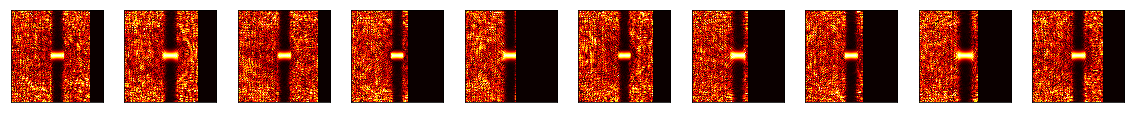

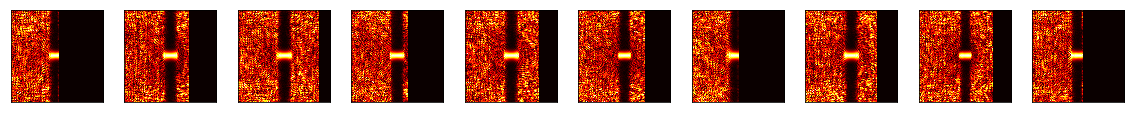

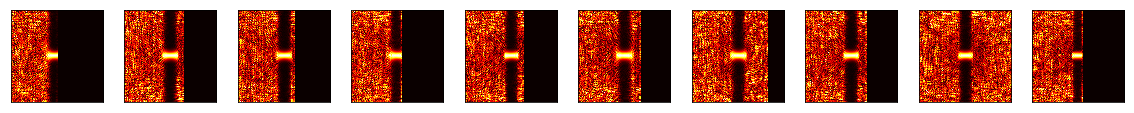

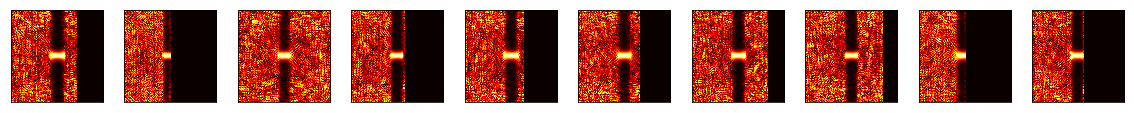

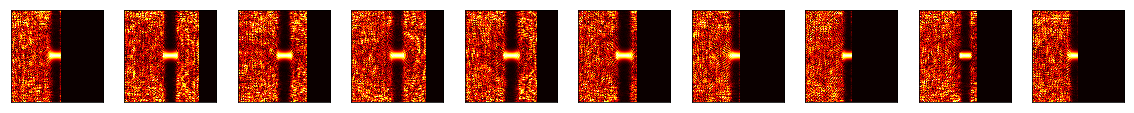

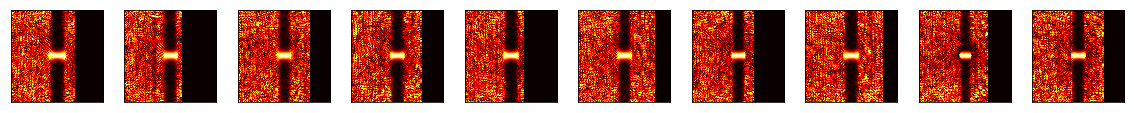

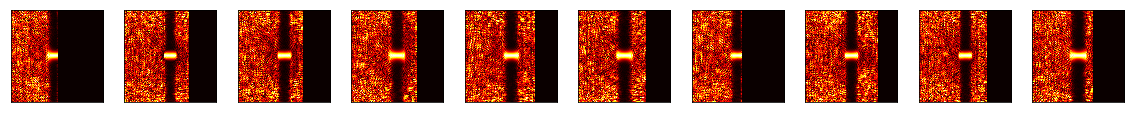

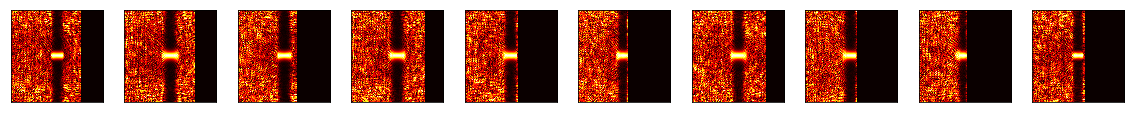

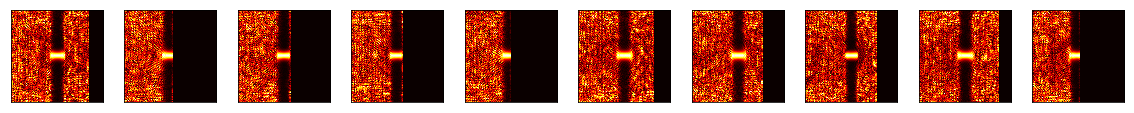

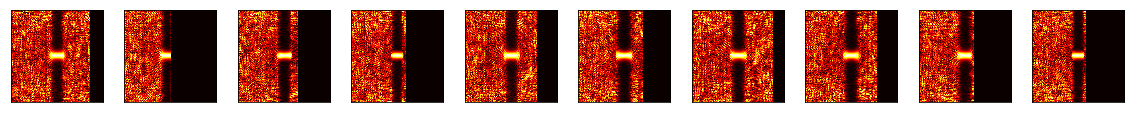

In [6]:
%matplotlib inline

nrows = 10
ncols = 10

for row in range(nrows):
    plt.figure(figsize=(20, 20))
    for col in range(ncols):
        curcol = col+1+(row*ncols)
        ax = plt.subplot(nrows, ncols, curcol)
        plt.imshow(DATASET[curcol, :, :], cmap='hot', interpolation='nearest')
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

- - -

# Construct CNN

In [10]:
try:
    del NETWORK
except:
    print("Network does not exist")

In [11]:
#Network parameters
input_shape = (1024, 1024, 1)
output_size = len(train_labels_ohe[0])
activation = 'relu'
optimizer = 'rmsprop'

#Create the encoder
NETWORK = models.Sequential()

#Layer 1
NETWORK.add(layers.Conv2D(128, (5,5), activation=activation, input_shape=input_shape))

#Pool
NETWORK.add(layers.MaxPooling2D((2,2)))

#Layer 2
NETWORK.add(layers.Conv2D(64, (6,6), activation=activation))

#Pool
NETWORK.add(layers.MaxPooling2D((2,2)))

#Layer 3
NETWORK.add(layers.Conv2D(32, (5,5), activation=activation))

#Pool
NETWORK.add(layers.MaxPooling2D((2,2)))

#Connect to a dense output layer - just like an FCN
NETWORK.add(layers.Flatten())
NETWORK.add(layers.Dense(16, activation=activation))
NETWORK.add(layers.Dense(output_size, activation='softmax'))

#Compile
NETWORK.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Save weights
NETWORK.save_weights('model_weights.h5')

#Print summary
print(NETWORK.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1020, 1020, 128)   3328      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 510, 510, 128)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 505, 505, 64)      294976    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 252, 252, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 248, 248, 32)      51232     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 492032)            0         
__________

- - -

# Do the Fit (SEE NOTE)

**NOTE: No need to run this here since it takes a VERY long time to train considering the size of the spatial grids!**

There is an associated model_trainer.py/model_trainer.sh batch script, which is set to run on a GPU.

In [ ]:
#Fitting parameters
patience = 10
max_epochs = 50
batch_size = 8

#Set callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=patience),
             ModelCheckpoint(filepath='model_best.h5', monitor='val_loss', save_best_only=True)]

#Fit
history = NETWORK.fit(train_grids, train_labels_ohe,
                        epochs=max_epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        validation_data=(test_grids, test_labels_ohe)
                     )

#Save the network -- No need for this if ModelCheckpoint is enabled
#NETWORK.save('trained_cnn.h5')

#Save the history
pickle.dump(history.history, open('model_history.pkl', 'wb'))

- - -

# Inspect Performance

In [18]:
#Delete current model and history if either exists
try:
    del NETWORK
except:
    print("Network does not exist")
try:
    del history
except:
    print("History does not exist")

#Load trained model
NETWORK = load_model('model_best.h5')
history = pickle.load(open('model_history.pkl', 'rb'))

#Overall performance for the test sample
test_loss, test_acc = NETWORK.evaluate(test_grids, test_labels_ohe)

#Individual predictions for each sample in the test set
predictions = NETWORK.predict(test_grids)

#Max probabilites for each rows
probs = np.max(predictions, axis=1)

#Predicted classes for each row
classes = np.argmax(predictions, axis=1)

#Performance details
training_vals_acc = history['acc']
training_vals_loss = history['loss']
valid_vals_acc = history['val_acc']
valid_vals_loss = history['val_loss']
iterations = len(training_vals_acc)

52/52 [==============================] - 20s 385ms/step


In [19]:
print("Test sample loss:", test_loss)
print("Test sample accuracy:", test_acc)

print("Label\t Pred\t Prob")
for label, cl, pr in zip(test_labels[:20], classes[:20], probs[:20]):
    print(label, "\t", cl, "\t", round(pr,3))

print("Number of iterations:",iterations)
print("Epoch\t Train Loss\t Train Acc\t Val Loss\t Val Acc")
for tl,ta,vl,va in zip(training_vals_loss,training_vals_acc,valid_vals_loss,valid_vals_acc):
    print(round(tl,5),'\t',round(ta,5),'\t',round(vl,5),'\t',round(va,5))

Test sample loss: 16.11809539794922
Test sample accuracy: 0.0
Label	 Pred	 Prob
1.06e-05 	 12 	 1.0
8.6e-06 	 12 	 1.0
7.6e-06 	 12 	 1.0
7.8e-06 	 12 	 1.0
1.14e-05 	 12 	 1.0
1.1e-05 	 12 	 1.0
7.6e-06 	 12 	 1.0
6.8e-06 	 12 	 1.0
9e-06 	 12 	 1.0
8.8e-06 	 12 	 1.0
1.14e-05 	 12 	 1.0
5.4e-06 	 12 	 1.0
1.14e-05 	 12 	 1.0
5.6e-06 	 12 	 1.0
5.02e-06 	 12 	 1.0
1.2e-05 	 12 	 1.0
8.4e-06 	 12 	 1.0
5.6e-06 	 12 	 1.0
9e-06 	 12 	 1.0
5.02e-06 	 12 	 1.0
Number of iterations: 11
Epoch	 Train Loss	 Train Acc	 Val Loss	 Val Acc
15.33582 	 0.02392 	 15.80813 	 0.01923
15.7325 	 0.02392 	 15.80813 	 0.01923
15.7325 	 0.02392 	 15.80813 	 0.01923
15.7325 	 0.02392 	 15.80813 	 0.01923
15.7325 	 0.02392 	 15.80813 	 0.01923
15.7325 	 0.02392 	 15.80813 	 0.01923
15.7325 	 0.02392 	 15.80813 	 0.01923
15.7325 	 0.02392 	 15.80813 	 0.01923
15.7325 	 0.02392 	 15.80813 	 0.01923
15.7325 	 0.02392 	 15.80813 	 0.01923
15.7325 	 0.02392 	 15.80813 	 0.01923


In [22]:
for key in history:
    print(key, ":", history[key], "\n")

val_loss : [15.808132024911734, 15.808132024911734, 15.808132024911734, 15.808132024911734, 15.808132024911734, 15.808132024911734, 15.808132024911734, 15.808132024911734, 15.808132024911734, 15.808132024911734, 15.808132024911734] 

val_acc : [0.019230769230769232, 0.019230769230769232, 0.019230769230769232, 0.019230769230769232, 0.019230769230769232, 0.019230769230769232, 0.019230769230769232, 0.019230769230769232, 0.019230769230769232, 0.019230769230769232, 0.019230769230769232] 

loss : [15.335820622421338, 15.732495029577228, 15.732495029577228, 15.732495029577228, 15.732495029577228, 15.732495029577228, 15.732495029577228, 15.732495029577228, 15.732495029577228, 15.732495029577228, 15.732495029577228] 

acc : [0.023923444976076555, 0.023923444976076555, 0.023923444976076555, 0.023923444976076555, 0.023923444976076555, 0.023923444976076555, 0.023923444976076555, 0.023923444976076555, 0.023923444976076555, 0.023923444976076555, 0.023923444976076555] 



In [23]:
enable_plotly_in_cell()

#Loss
data_train = go.Scatter(
    x=np.array(range(0,len(history['loss']))),
    y=history['loss'],
    mode='markers',
    name="Train data"
)
data_test = go.Scatter(
    x=np.array(range(0,len(history['val_loss']))),
    y=history['val_loss'],
    mode='markers',
    name="Test data"
)
iplot(dict(data=[data_train,data_test]))

#Accuracy
data_train = go.Scatter(
    x=np.array(range(0,len(history['acc']))),
    y=history['acc'],
    mode='markers',
    name="Train data"
)
data_test = go.Scatter(
    x=np.array(range(0,len(history['val_acc']))),
    y=history['val_acc'],
    mode='markers',
    name="Test data"
)
iplot(dict(data=[data_train,data_test]))